Data: 26, Nodes: 4244, Edges: 6041
{4060029000: [126.512734734648, 33.2546781470705], 4060187801: [126.393318242941, 33.3024873661656], 4060014200: [126.427824763833, 33.2404562739723], 4050113000: [126.667921008318, 33.5294259271958], 4050113700: [126.702717929053, 33.5433495414616], 4050113900: [126.693206207319, 33.5500237666183], 4060000800: [126.478039080718, 33.2511516704185], 4060003403: [126.595401810657, 33.259624267661], 4060004001: [126.612293095372, 33.2611697419915], 4060004201: [126.428245623643, 33.258049186505], 4060073300: [126.467102315343, 33.263421015703], 4060073400: [126.474326735403, 33.2561718396282], 4060073900: [126.514023434851, 33.2366074758841], 4060074300: [126.475651731667, 33.2362573635155], 4060076200: [126.561106833762, 33.2468565391276], 4050000503: [126.489959245415, 33.41828117736], 4050000600: [126.616698292577, 33.4191031477377], 4050129700: [126.258499828867, 33.3048245714679], 4050130300: [126.259139099184, 33.4094155336075], 4050164300: [126.40

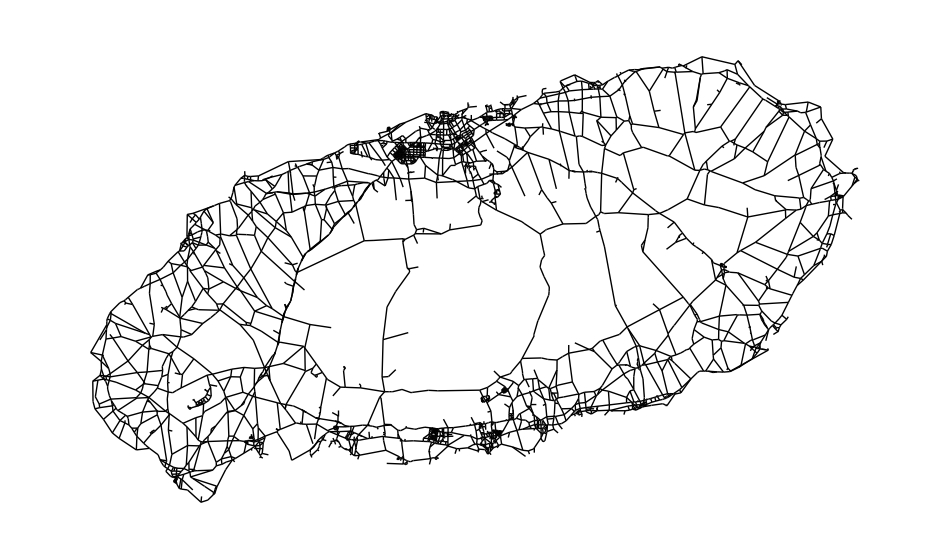

In [19]:
import pandas as pd
import numpy as np
import networkx as nx
from haversine import haversine
import cv2
import os
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

nodes = pd.read_csv('data/Jeju_nodes.csv', encoding='utf-8')
links = pd.read_csv('data/Jeju_links.csv', encoding='cp949')
car = pd.read_csv('data/Jeju_car.csv', encoding='cp949')

nodes = nodes[['Id','NODE_NAME','latitude','longitude', 'average population']]
links = links[['Source','Target', '시간']]
source_in = links['Source'].apply(lambda x : x in list(nodes['Id'])) # check Sources are in jeju
target_in = links['Target'].apply(lambda x : x in list(nodes['Id'])) # check Targets are in jeju
# source_in and target_in are boolean type pandas.Series which contains True or False
jeju_links = links[source_in & target_in] # contain if both target and source are contained in jeju

G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
# make a dictionary for node position

def connectRes(graph, df): # df는 idx, latitude, longitude가 있어야함
    nodes_latitude = nx.get_node_attributes(graph, 'latitude')
    nodes_longitude = nx.get_node_attributes(graph, 'longitude')
    for idx, row in df.iterrows():
        distances ={}
        for keyLong, valLat in nodes_latitude.items():
            nodesPos = (valLat, nodes_longitude[keyLong])
            curPos = (row['latitude'], row['longitude'])
            distances[keyLong] = haversine(nodesPos, curPos, unit='km')
        nearest_node = min(distances, key=distances.get)
        graph.add_node(idx, Label=idx, latitude=row['latitude'], longitude=row['longitude']) ##노드이름은 4050000000이하로 설정
        w = distances[nearest_node]*1000/666 #단위 변환 km->m(*1000), 거리(m)->시간(분) (40km/h = 666m/s)
        graph.add_edge(nearest_node, idx, weight=w) 
    return graph
G = connectRes(G, car)
print(f"Data: {len(car)}, Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")

pos = {}
for node in G.nodes(data=True):
    pos[node[0]] = [node[1]['longitude'], node[1]['latitude']]
print(pos)

# "G" is a network, "nodelist" is a list of node to select
def draw(G, nodelist=None, select_color = 'red', title = ''):
    plt.figure(figsize= (12, 7))
    plt.cla()
    plt.axis('off')
    if title:
        plt.title(title, loc='left')
    nx.draw_networkx(G, pos=pos, node_size = 0, with_labels=False)
    if nodelist != None:
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=select_color, node_size=1)
        edge_colors = [select_color if (u in nodelist and v in nodelist) else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.show()
def saveImg(G, nodelist=None, select_color = 'red', name = 'saveImg.png', title=''):
    plt.figure(figsize= (12, 7))
    plt.axis('off')
    if title:
        plt.title(title, loc='left')
    nx.draw_networkx(G, pos=pos, node_size = 0, with_labels=False)
    if nodelist != None:
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=select_color, node_size=1)
        edge_colors = [select_color if (u in nodelist and v in nodelist) else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.savefig(name, bbox_inches='tight', pad_inches=0.2, transparent = True)

print(nodes.columns)
print(nodes.head())
saveImg(G)

119 index list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
total population in jeju: 624051.027987
total population in area: 480734.17311324406
service area 5min time: 0.416339635848999


C:\Flutter\bin\ipykernel_22008\733621746.py:65: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors)


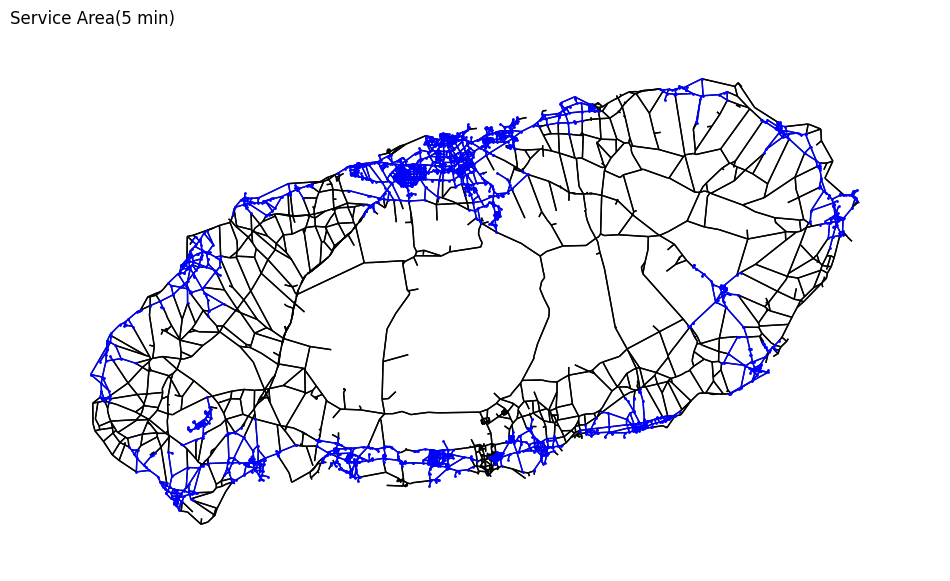

In [4]:
def serviceArea(graph, nodelist = [], w =5):
    ret = {}
    for node in nodelist:
        shortest_paths = nx.single_source_dijkstra_path_length(graph, node, cutoff=w, weight='weight')
        tmp=ret
        for key in set(shortest_paths.keys()).intersection(ret.keys()):
            tmp[key] = min(shortest_paths[key], ret[key])
        tmp.update({key: shortest_paths[key] for key in set(shortest_paths.keys()) - set(ret.keys())})
        tmp.update({key: ret[key] for key in set(ret.keys()) - set(shortest_paths.keys())})
        ret = tmp
    return ret

t1 = time.time()
area = {}
carlist = car.index.tolist()
print(f"119 index list: {carlist}")
area = serviceArea(G, carlist, w=5)
sum = 0
for key, val in area.items():
    if key >1000:
        sum += nodes.loc[nodes['Id'] == key, 'average population'].values[0]
print(f"total population in jeju: {nodes['average population'].sum()}")
print(f"total population in area: {sum}")
t2 = time.time()
print(f'service area 5min time: {t2-t1}')
draw(G, area, 'blue', title="Service Area(5 min)")


In [3]:
carlist = car.index.tolist()
for carNum in carlist:
    area = serviceArea(G, [carNum], w=5)
    sum = 0
    for key, val in area.items():
        if key >1000:
            sum += nodes.loc[nodes['Id'] == key, 'average population'].values[0]
    print(f"car{carNum} people: {sum}")


car0 people: 107658.45911000013
car1 people: 143586.1393929997
car2 people: 143586.1393929997
car3 people: 78184.13036299996
car4 people: 130833.87741599997
car5 people: 109351.02311100012
car6 people: 90001.12235399999
car7 people: 65130.85464600007
car8 people: 4745.449445
car9 people: 6601.956501000004
car10 people: 114825.37565100011
car11 people: 23830.92705499998
car12 people: 18824.07431500001
car13 people: 2588.42697
car14 people: 2588.42697
car15 people: 13172.827168000036
car16 people: 7423.840942000001
car17 people: 7423.840942000001
car18 people: 4865.221053999998
car19 people: 7142.015082000001
car20 people: 9493.291222250016
car21 people: 27739.236316000053
car22 people: 4778.749267999998
car23 people: 27739.236316000053
car24 people: 1232.8453620000007
car25 people: 7714.513183999995
car26 people: 4123.814433000002
car27 people: 9768.294656999999
car28 people: 7423.173680000009
car29 people: 4114.736445000003
car30 people: 1232.8453620000007


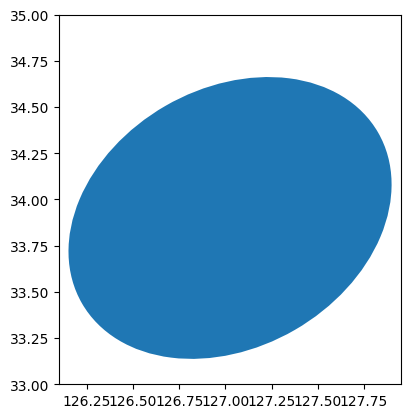

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

jeju_bounds = {
    'min_lat': 33.2,  # 최소 위도
    'max_lat': 34.6,  # 최대 위도
    'min_lon': 126.1,  # 최소 경도
    'max_lon': 127.95   # 최대 경도
}

# 제주도 중심에 기울어진 타원의 속성 설정
center_lat = (jeju_bounds['min_lat'] + jeju_bounds['max_lat']) / 2
center_lon = (jeju_bounds['min_lon'] + jeju_bounds['max_lon']) / 2
ellipse_width = jeju_bounds['max_lon'] - jeju_bounds['min_lon']
ellipse_height = jeju_bounds['max_lat'] - jeju_bounds['min_lat']
ellipse_angle = 15  # 타원의 기울기 설정

ellipse = Ellipse((center_lon, center_lat), width=ellipse_width, height=ellipse_height, angle=ellipse_angle)

# 그래프 생성
fig, ax = plt.subplots()

# 타원 추가
ax.add_patch(ellipse)
ax.set_xlim(jeju_bounds['min_lon'], jeju_bounds['max_lon'])  # x축 범위 설정
ax.set_ylim(33, 35)  # y축 범위 설정
ax.set_aspect('equal')  # x축과 y축의 스케일을 동일하게 설정하여 원형태 유지

# 그래프 출력
plt.savefig('ellipse.png')
plt.show()